In [1]:
import os
import joblib
import pickle
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from keras import Sequential, Model
from keras.callbacks import Callback

In [2]:
# GPU
sf.limit_gpu_memory(8 * 1024)
sf.gpu_check()

True

## Business Understanding
Bij het trainen van een model zijn de effecten meestal niet direct zichtbaar na de eerste 5 epochs. Grote verschillen zijn meestal pas na grotere tijdsintervallen te zien. Om die reden is het goed om te experimenteren met verschillende modelopstellingen op grotere schaal.

Er is een begin gemaakt aan een grootschalige training in Grote_Training.ipynb. In die notebook wordt zowel een Analyzer als een Reconstructor getrained in de volgende opstelling:

Learning rate: 0.002

Analyser:

    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
Reconstructor:

    Conv2DTranspose,
    Conv2DTranspose,
    Conv2D

In dit notebook worden de Analyzer en Reconstructor in een nieuwe opstelling getrained. Deze opstelling gaat er als volgt uitzien:

Learning rate: 0.001

Analyser:

    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
Reconstructor:

    Conv2DTranspose,
    Conv2DTranspose,
    Conv2DTranspose,
    Conv2D

Hierdoor wordt de afbeelding nog een slag kleiner gemaakt dan in de vorige opstelling. Dit zorgt ervoor dat de reconstructor minder informatie krijgt om de CT-Scan mee te herstellen. Aangezien de learning rate van 0.002 naar 0.001 is gezet is de kans groter dat hij in een lokaal minimum vast komt te zitten. Echter, We hebben bij de vorige training gezien dat het model uiteindelijk in een NaN gebied terecht komt. Dit is tevens niet de bedoeling, vandaar dat het wellicht hiermee wordt verholpen. 

---
#### Dit notebook is opgebouwd uit de volgende bronnen:
- N02. Inlezen data (loading) v3.0.ipynb van Chula Bruggeling (Data Understanding)
- read_dicom_files.ipynb van Dr. Paul Hiemstra (Data Understanding)
- split_models.ipynb van Vincent Dorenbosch (Data Preperation)
- split_models.ipynb van Vincent Dorenbosch (Modelling)
- Grote_Training.ipynb van Youri de Beurs (Modelling)
- triplets.ipynb van Hein Kamphuis (Evaluation)
- Trainings_Video.ipynb van Youri de Beurs (Evaluation)

## Data preparation

In [3]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slices = joblib.load(SLICES_JOBLIB_PATH)

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 15
PATCH_SIZE = 32

corrupted_slices = np.array([sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE) for slice in slices])

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Modelling

In [6]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same'),
            layers.Conv2D(128, kernel_size=3, padding='same'),
            layers.Conv2D(128, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),
            
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [8]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 256)),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
            layers.Conv2D(1, kernel_size=3, padding='same'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 512)     1180160   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 256)     1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 2,656,257
Trainable params: 2,656,257
Non-trainable params: 0
_________________________________________________________________


In [9]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
MODEL_NAME = 'medium_model_LR_0.001_'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, NUMBER_OF_SWITCHES, PATCH_SIZE)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor.h5'))
        model.save(os.path.join(model_folder, 'complete.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/500
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 52710.4727INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:

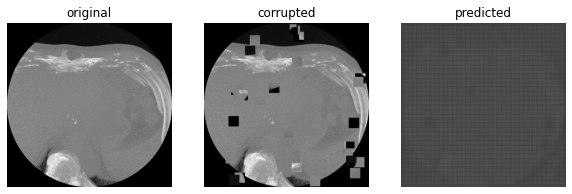

Epoch 2/500
51/51 [==============================] - 16s 324ms/step - loss: 343.0423 - val_loss: 20.5798
Epoch 3/500
51/51 [==============================] - 17s 325ms/step - loss: 6.4078 - val_loss: 2.2229
Epoch 4/500
51/51 [==============================] - 17s 325ms/step - loss: 1.5243 - val_loss: 1.0658
Epoch 5/500
51/51 [==============================] - 17s 326ms/step - loss: 0.9234 - val_loss: 0.7927
Epoch 6/500
51/51 [==============================] - 17s 325ms/step - loss: 0.7412 - val_loss: 0.6684


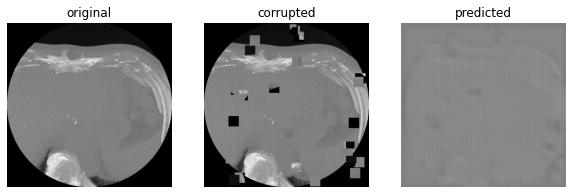

Epoch 7/500
51/51 [==============================] - 17s 326ms/step - loss: 0.6398 - val_loss: 0.5851
Epoch 8/500
51/51 [==============================] - 17s 325ms/step - loss: 0.5664 - val_loss: 0.5210
Epoch 9/500
51/51 [==============================] - 17s 326ms/step - loss: 0.5092 - val_loss: 0.4720
Epoch 10/500
51/51 [==============================] - 17s 325ms/step - loss: 0.4642 - val_loss: 0.4324
Epoch 11/500
51/51 [==============================] - 17s 325ms/step - loss: 0.4274 - val_loss: 0.3988


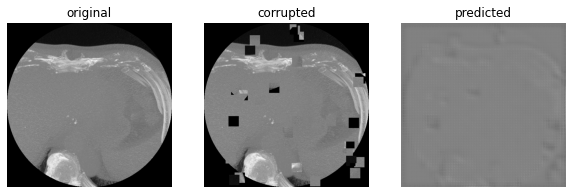

Epoch 12/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3957 - val_loss: 0.3719
Epoch 13/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3704 - val_loss: 0.3477
Epoch 14/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3484 - val_loss: 0.3278
Epoch 15/500
51/51 [==============================] - 17s 326ms/step - loss: 0.3292 - val_loss: 0.3196
Epoch 16/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3146 - val_loss: 0.3008


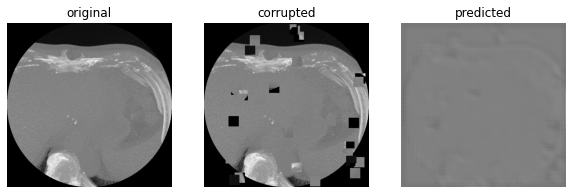

Epoch 17/500
51/51 [==============================] - 17s 326ms/step - loss: 0.2974 - val_loss: 0.2807
Epoch 18/500
51/51 [==============================] - 17s 326ms/step - loss: 0.2832 - val_loss: 0.2729
Epoch 19/500
51/51 [==============================] - 17s 325ms/step - loss: 0.2714 - val_loss: 0.2565
Epoch 20/500
51/51 [==============================] - 17s 325ms/step - loss: 0.2587 - val_loss: 0.2459
Epoch 21/500
51/51 [==============================] - 17s 326ms/step - loss: 0.2483 - val_loss: 0.2409


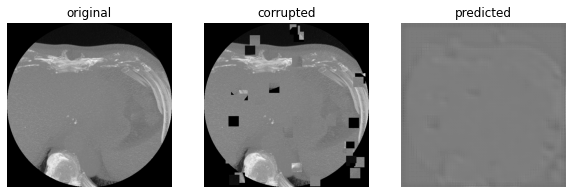

Epoch 22/500
51/51 [==============================] - 17s 325ms/step - loss: 0.2395 - val_loss: 0.2278
Epoch 23/500
51/51 [==============================] - 17s 325ms/step - loss: 0.2290 - val_loss: 0.2189
Epoch 24/500
51/51 [==============================] - 17s 326ms/step - loss: 0.2203 - val_loss: 0.2118
Epoch 25/500
51/51 [==============================] - 17s 326ms/step - loss: 0.2119 - val_loss: 0.2045
Epoch 26/500
51/51 [==============================] - 17s 325ms/step - loss: 0.2040 - val_loss: 0.1953


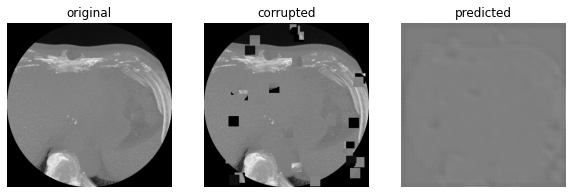

Epoch 27/500
51/51 [==============================] - 17s 328ms/step - loss: 0.1969 - val_loss: 0.1899
Epoch 28/500
51/51 [==============================] - 17s 327ms/step - loss: 0.1904 - val_loss: 0.1869
Epoch 29/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1858 - val_loss: 0.1751
Epoch 30/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1778 - val_loss: 0.1707
Epoch 31/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1722 - val_loss: 0.1661


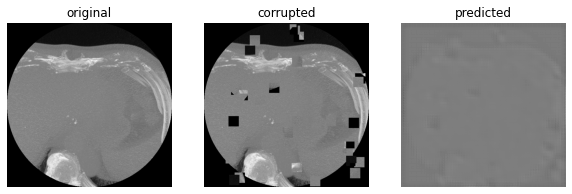

Epoch 32/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1670 - val_loss: 0.1585
Epoch 33/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1614 - val_loss: 0.1539
Epoch 34/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1559 - val_loss: 0.1493
Epoch 35/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1510 - val_loss: 0.1446
Epoch 36/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1458 - val_loss: 0.1404


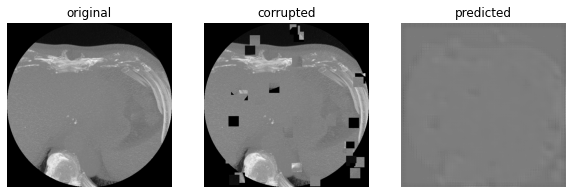

Epoch 37/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1415 - val_loss: 0.1360
Epoch 38/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1370 - val_loss: 0.1325
Epoch 39/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1334 - val_loss: 0.1293
Epoch 40/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1297 - val_loss: 0.1240
Epoch 41/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1248 - val_loss: 0.1208


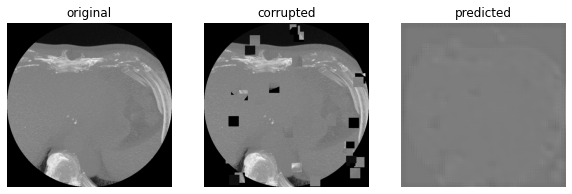

Epoch 42/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1219 - val_loss: 0.1194
Epoch 43/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1179 - val_loss: 0.1160
Epoch 44/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1152 - val_loss: 0.1101
Epoch 45/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1137 - val_loss: 0.1069
Epoch 46/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1099 - val_loss: 0.1069


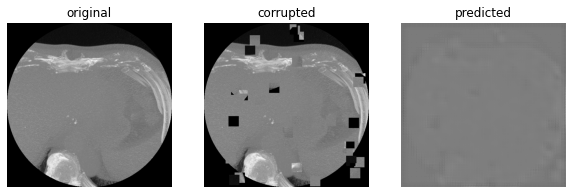

Epoch 47/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1071 - val_loss: 0.1001
Epoch 48/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1019 - val_loss: 0.0977
Epoch 49/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0991 - val_loss: 0.0972
Epoch 50/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0963 - val_loss: 0.0943
Epoch 51/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0965 - val_loss: 0.0890


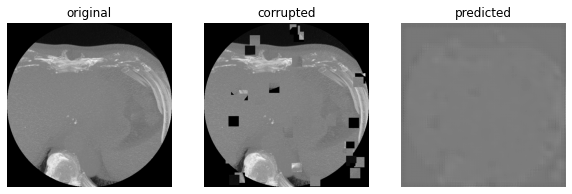

Epoch 52/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0919 - val_loss: 0.0864
Epoch 53/500
51/51 [==============================] - 17s 327ms/step - loss: 0.0886 - val_loss: 0.0845
Epoch 54/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0871 - val_loss: 0.0826
Epoch 55/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0855 - val_loss: 0.0882
Epoch 56/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0871 - val_loss: 0.0771


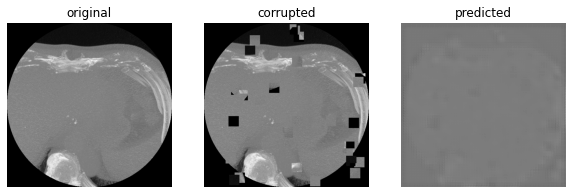

Epoch 57/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0822 - val_loss: 0.0775
Epoch 58/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0851 - val_loss: 0.0843
Epoch 59/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0974 - val_loss: 0.0722
Epoch 60/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0823 - val_loss: 0.0708
Epoch 61/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0961 - val_loss: 0.0691


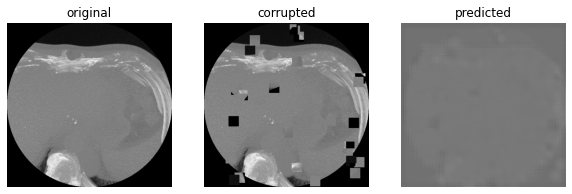

Epoch 62/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1551 - val_loss: 0.1092
Epoch 63/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3248 - val_loss: 0.0618
Epoch 64/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1065 - val_loss: 0.0587
Epoch 65/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0651 - val_loss: 0.0598
Epoch 66/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1755 - val_loss: 0.0752


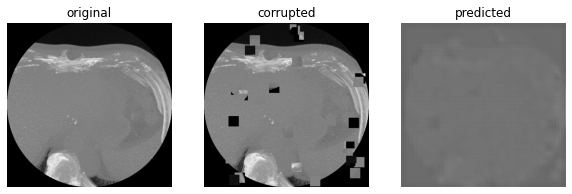

Epoch 67/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1425 - val_loss: 0.0663
Epoch 68/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0840 - val_loss: 0.0539
Epoch 69/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1362 - val_loss: 0.0516
Epoch 70/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1032 - val_loss: 0.0474
Epoch 71/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1651 - val_loss: 0.0591


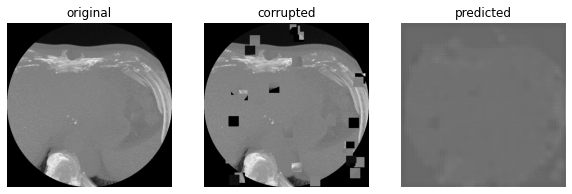

Epoch 72/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0923 - val_loss: 0.0519
Epoch 73/500
51/51 [==============================] - 17s 325ms/step - loss: 0.1570 - val_loss: 0.0449
Epoch 74/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0513 - val_loss: 0.0420
Epoch 75/500
51/51 [==============================] - 17s 326ms/step - loss: 0.1778 - val_loss: 0.1210
Epoch 76/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3116 - val_loss: 0.0377


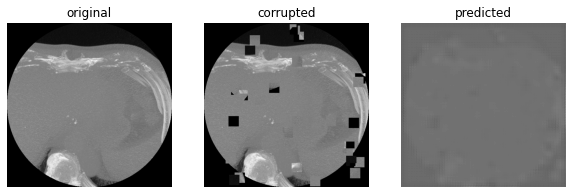

Epoch 77/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0389 - val_loss: 0.0376
Epoch 78/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0391 - val_loss: 0.0351
Epoch 79/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0388 - val_loss: 0.0467
Epoch 80/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0588 - val_loss: 0.0340
Epoch 81/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0460 - val_loss: 0.0520


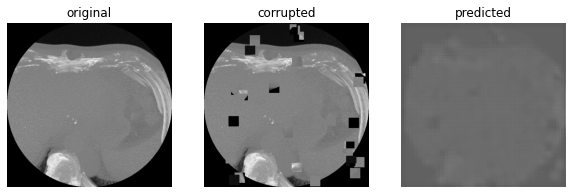

Epoch 82/500
51/51 [==============================] - 17s 326ms/step - loss: 0.3900 - val_loss: 0.0800
Epoch 83/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0634 - val_loss: 0.0312
Epoch 84/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0305 - val_loss: 0.0281
Epoch 85/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0293 - val_loss: 0.0301
Epoch 86/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0343 - val_loss: 0.0289


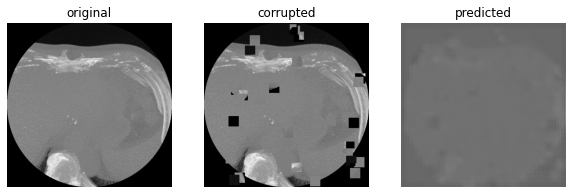

Epoch 87/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0288 - val_loss: 0.0264
Epoch 88/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0303 - val_loss: 0.0336
Epoch 89/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0523 - val_loss: 0.0336
Epoch 90/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0502 - val_loss: 0.0261
Epoch 91/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0379 - val_loss: 0.1002


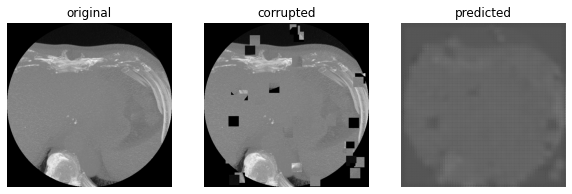

Epoch 92/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3815 - val_loss: 0.0495
Epoch 93/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0334 - val_loss: 0.0208
Epoch 94/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0215 - val_loss: 0.0214
Epoch 95/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0219 - val_loss: 0.0245
Epoch 96/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0220 - val_loss: 0.0197


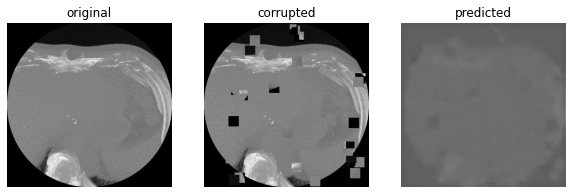

Epoch 97/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0206 - val_loss: 0.0218
Epoch 98/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0258 - val_loss: 0.0267
Epoch 99/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0373 - val_loss: 0.0189
Epoch 100/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0199 - val_loss: 0.0182
Epoch 101/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0209 - val_loss: 0.0180


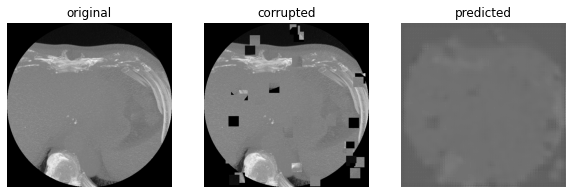

Epoch 102/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0214 - val_loss: 0.0220
Epoch 103/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0763 - val_loss: 0.0175
Epoch 104/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0242 - val_loss: 0.0164
Epoch 105/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0220 - val_loss: 0.0162
Epoch 106/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0262 - val_loss: 0.0409


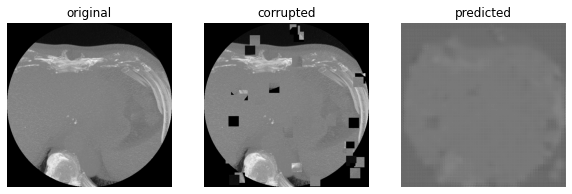

Epoch 107/500
51/51 [==============================] - 17s 326ms/step - loss: 0.2721 - val_loss: 0.0149
Epoch 108/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 109/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 110/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 111/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0139 - val_loss: 0.0132


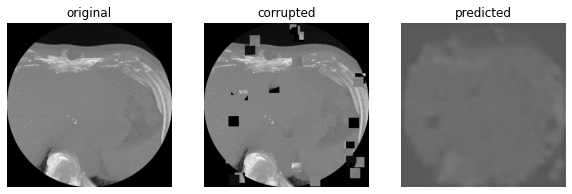

Epoch 112/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 113/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 114/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0188 - val_loss: 0.0143
Epoch 115/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0149 - val_loss: 0.0127
Epoch 116/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0140 - val_loss: 0.0187


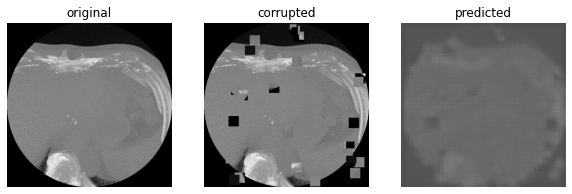

Epoch 117/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0410 - val_loss: 0.0125
Epoch 118/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0147 - val_loss: 0.0115
Epoch 119/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0227 - val_loss: 0.0121
Epoch 120/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0300 - val_loss: 0.0924
Epoch 121/500
51/51 [==============================] - 17s 325ms/step - loss: 0.3260 - val_loss: 0.0148


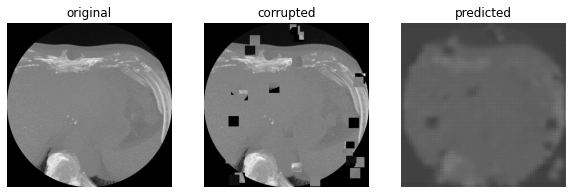

Epoch 122/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 123/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 124/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 125/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 126/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0090 - val_loss: 0.0087


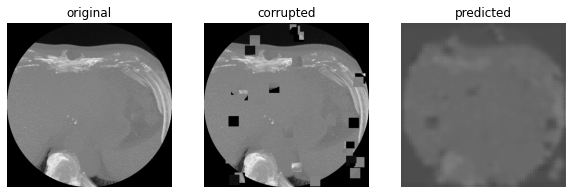

Epoch 127/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 128/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 129/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 130/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 131/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0087 - val_loss: 0.0090


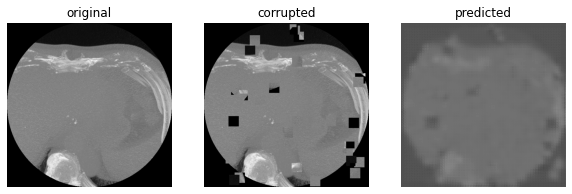

Epoch 132/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 133/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 134/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 135/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 136/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0087 - val_loss: 0.0081


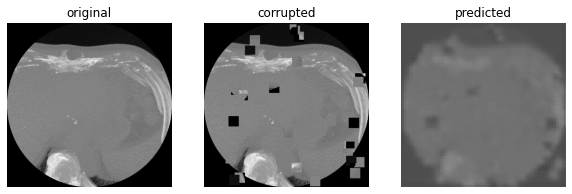

Epoch 137/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 138/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 139/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 140/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 141/500
51/51 [==============================] - 17s 327ms/step - loss: 0.0182 - val_loss: 0.0076


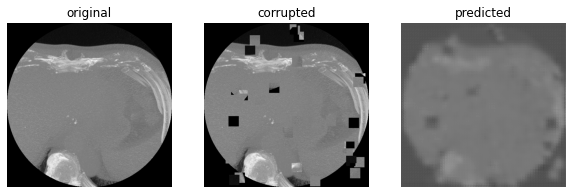

Epoch 142/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 143/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0098 - val_loss: 0.0155
Epoch 144/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0406 - val_loss: 0.0104
Epoch 145/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0117 - val_loss: 0.0072
Epoch 146/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0084 - val_loss: 0.0071


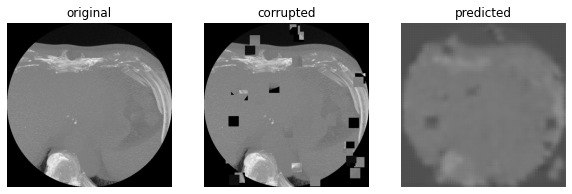

Epoch 147/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 148/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0126 - val_loss: 0.0104
Epoch 149/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0344 - val_loss: 0.0066
Epoch 150/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 151/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0071 - val_loss: 0.0079


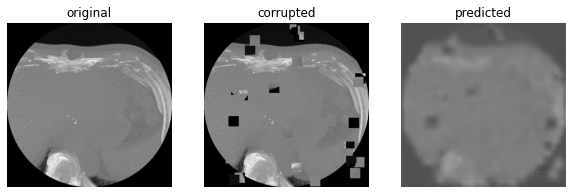

Epoch 152/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0097 - val_loss: 0.0062
Epoch 153/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 154/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0132 - val_loss: 0.0071
Epoch 155/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0262 - val_loss: 0.0061
Epoch 156/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0066 - val_loss: 0.0059


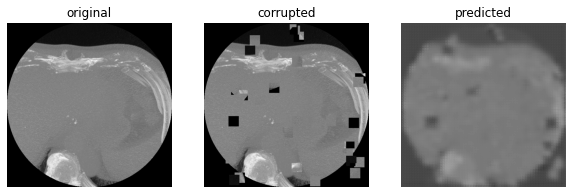

Epoch 157/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 158/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0116 - val_loss: 0.0062
Epoch 159/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0120 - val_loss: 0.0057
Epoch 160/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0093 - val_loss: 0.0296
Epoch 161/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0966 - val_loss: 0.0104


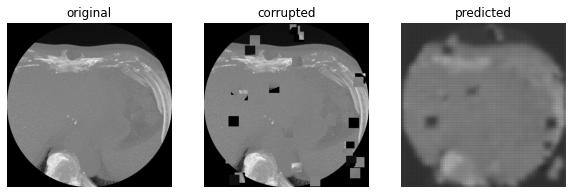

Epoch 162/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 163/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 164/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 165/500
51/51 [==============================] - 17s 327ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 166/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0054 - val_loss: 0.0052


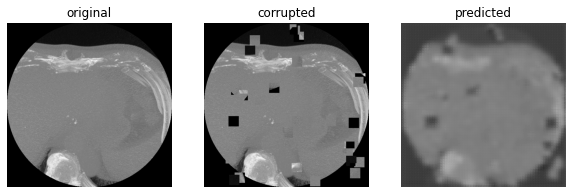

Epoch 167/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 168/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 169/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 170/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 171/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0053 - val_loss: 0.0051


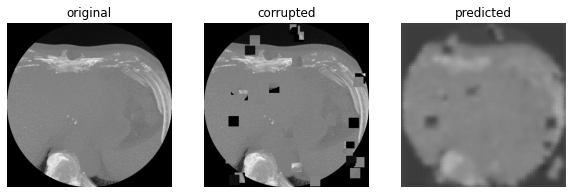

Epoch 172/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 173/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 174/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 175/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 176/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0056 - val_loss: 0.0051


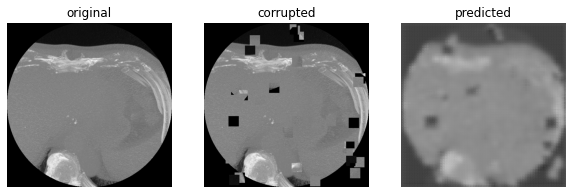

Epoch 177/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0066 - val_loss: 0.0131
Epoch 178/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0879 - val_loss: 0.0072
Epoch 179/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 180/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 181/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0048 - val_loss: 0.0047


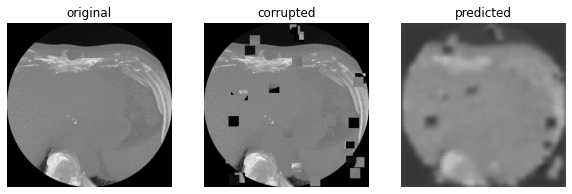

Epoch 182/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 183/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 184/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 185/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 186/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0046


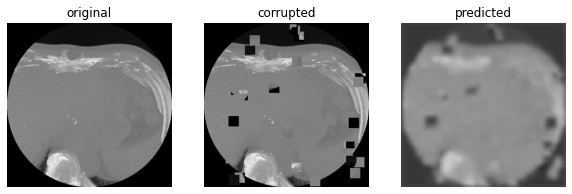

Epoch 187/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 188/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 189/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 190/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 191/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0047 - val_loss: 0.0045


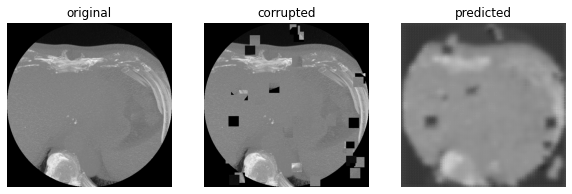

Epoch 192/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 193/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 194/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 195/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 196/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0050 - val_loss: 0.0045


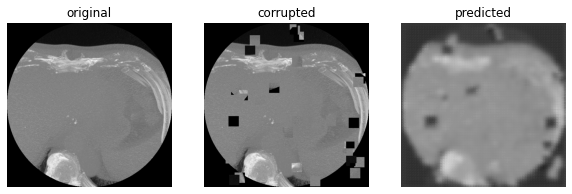

Epoch 197/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 198/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 199/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0124 - val_loss: 0.0047
Epoch 200/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 201/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0048 - val_loss: 0.0044


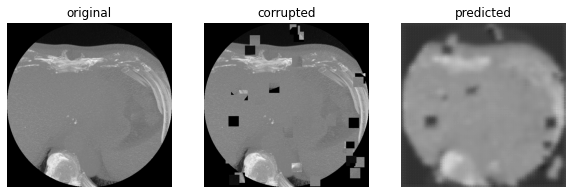

Epoch 202/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 203/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0191 - val_loss: 0.0051
Epoch 204/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 205/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 206/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0045 - val_loss: 0.0043


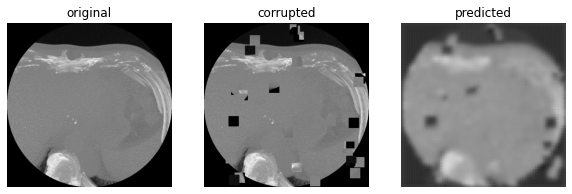

Epoch 207/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 208/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 209/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 210/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0155 - val_loss: 0.0044
Epoch 211/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0045 - val_loss: 0.0042


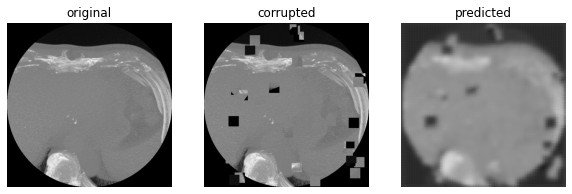

Epoch 212/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 213/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 214/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 215/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 216/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0046 - val_loss: 0.0049


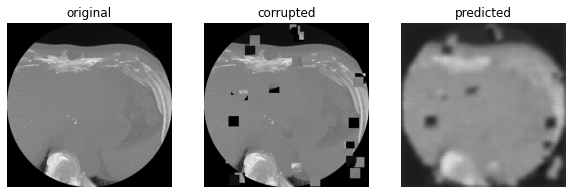

Epoch 217/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0123 - val_loss: 0.0047
Epoch 218/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 219/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 220/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 221/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0045 - val_loss: 0.0043


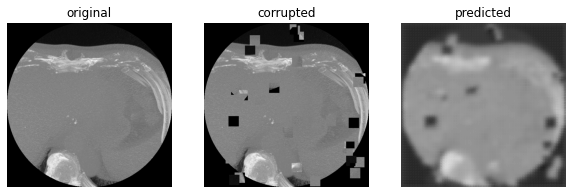

Epoch 222/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 223/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 224/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 225/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 226/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0054 - val_loss: 0.0044


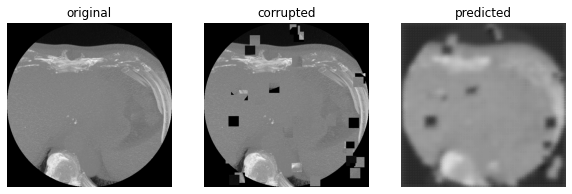

Epoch 227/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 228/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch 229/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0206 - val_loss: 0.0046
Epoch 230/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 231/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0042 - val_loss: 0.0041


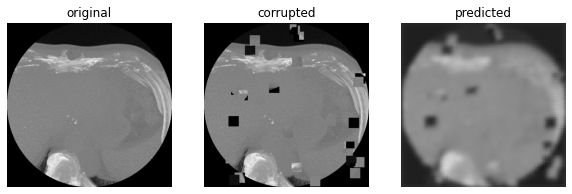

Epoch 232/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 233/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 234/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 235/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 236/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040


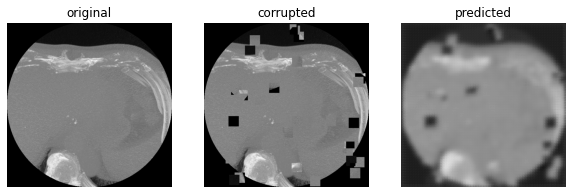

Epoch 237/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 238/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 239/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 240/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 241/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040


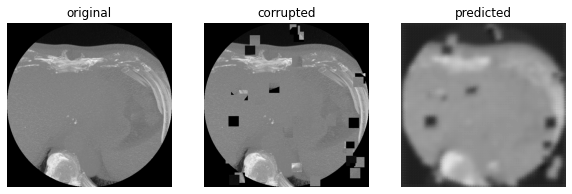

Epoch 242/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 243/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 244/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 245/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0047 - val_loss: 0.0077
Epoch 246/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0182 - val_loss: 0.0043


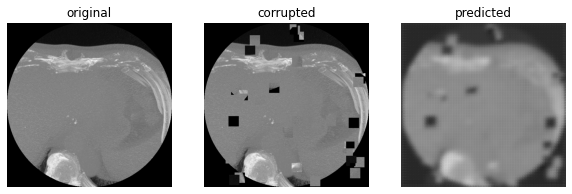

Epoch 247/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 248/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 249/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 250/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 251/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040


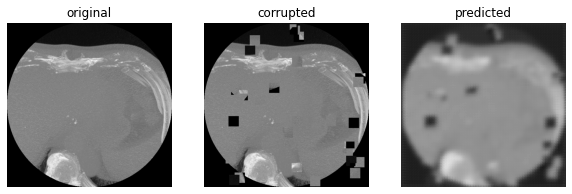

Epoch 252/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 253/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 254/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 255/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 256/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039


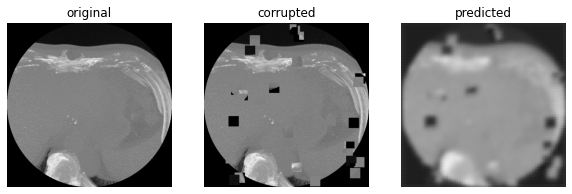

Epoch 257/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 258/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 259/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 260/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 261/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039


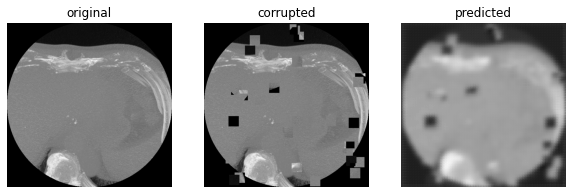

Epoch 262/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 263/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 264/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 265/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 266/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0044 - val_loss: 0.0040


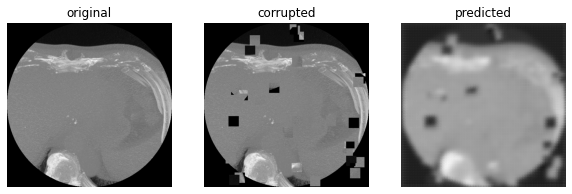

Epoch 267/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 268/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 269/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 270/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 271/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0038


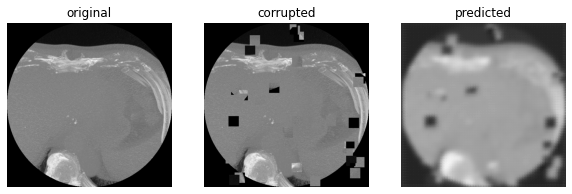

Epoch 272/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 273/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 274/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 275/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 276/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0038


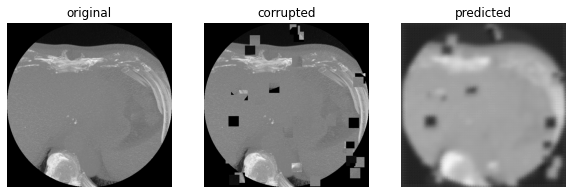

Epoch 277/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 278/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 279/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 280/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 281/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0041 - val_loss: 0.0038


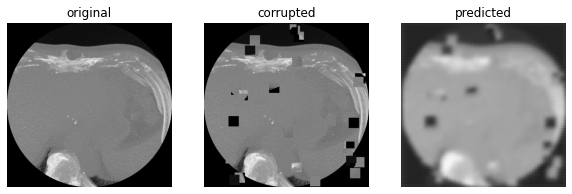

Epoch 282/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 283/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 284/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 285/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 286/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0042 - val_loss: 0.0038


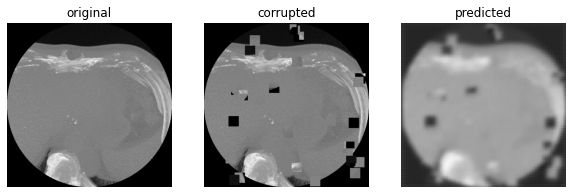

Epoch 287/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 288/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0040 - val_loss: 0.0060
Epoch 289/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0166 - val_loss: 0.0045
Epoch 290/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 291/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0041 - val_loss: 0.0039


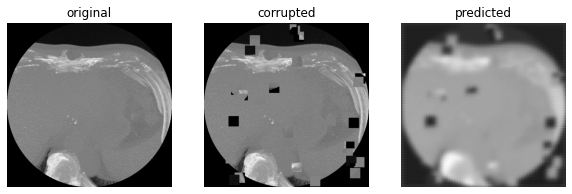

Epoch 292/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 293/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 294/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 295/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 296/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0038


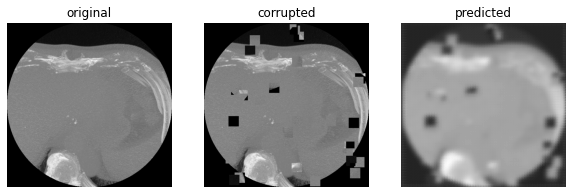

Epoch 297/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 298/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 299/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 300/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 301/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0038 - val_loss: 0.0037


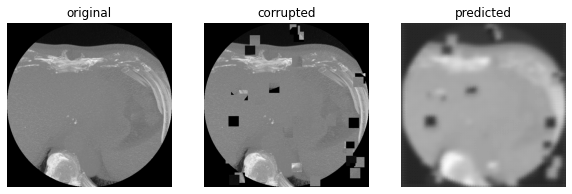

Epoch 302/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 303/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 304/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 305/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 306/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037


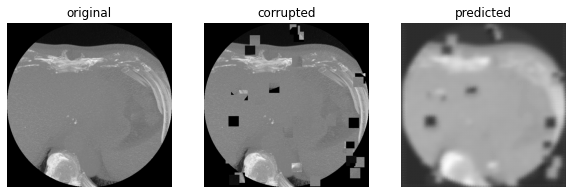

Epoch 307/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 308/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 309/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 310/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 311/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0037


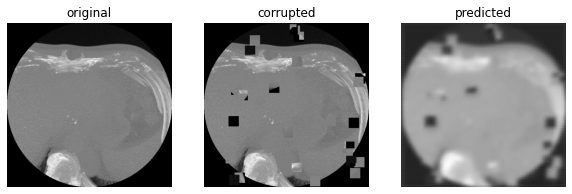

Epoch 312/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 313/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 314/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 315/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 316/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0038 - val_loss: 0.0036


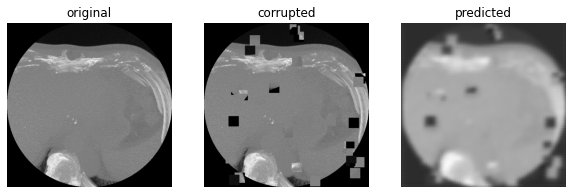

Epoch 317/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 318/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 319/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 320/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 321/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0040 - val_loss: 0.0036


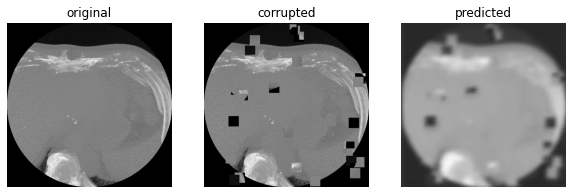

Epoch 322/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 323/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 324/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 325/500
51/51 [==============================] - 17s 326ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 326/500
51/51 [==============================] - 17s 325ms/step - loss: 0.0039 - val_loss: 0.0074


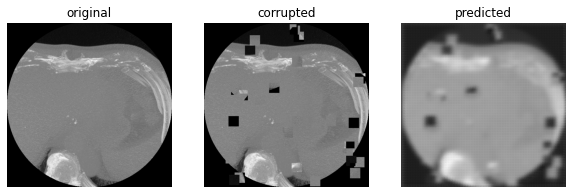

Epoch 327/500
51/51 [==============================] - 16s 321ms/step - loss: nan - val_loss: nan
Epoch 328/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 329/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 330/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 331/500
51/51 [==============================] - 16s 316ms/step - loss: nan - val_loss: nan


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


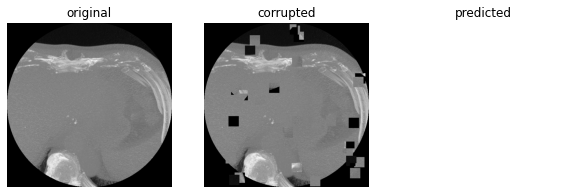

Epoch 332/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 333/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 334/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 335/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 336/500
51/51 [==============================] - 16s 314ms/step - loss: nan - val_loss: nan


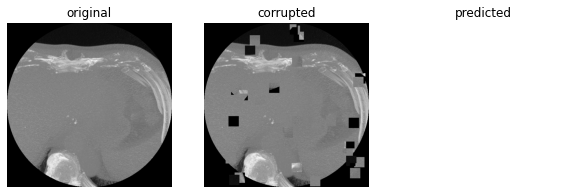

Epoch 337/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 338/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 339/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 340/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 341/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


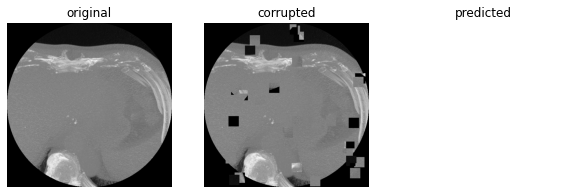

Epoch 342/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 343/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 344/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 345/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 346/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


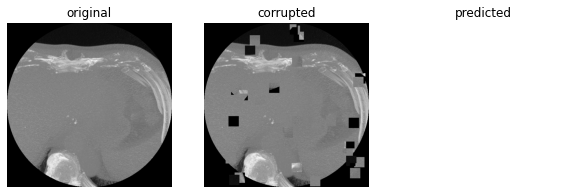

Epoch 347/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 348/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 349/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 350/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 351/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


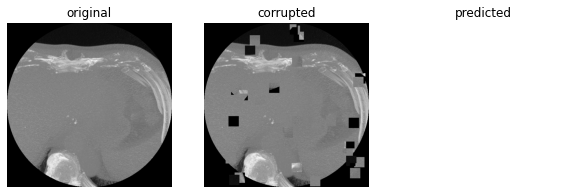

Epoch 352/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 353/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 354/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 355/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 356/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan


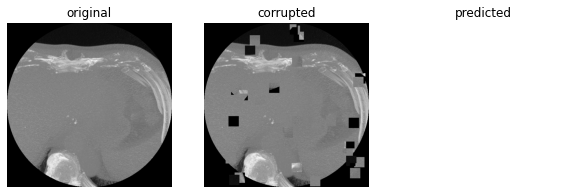

Epoch 357/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 358/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 359/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 360/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 361/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan


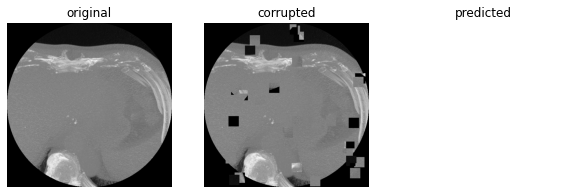

Epoch 362/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 363/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 364/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 365/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 366/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


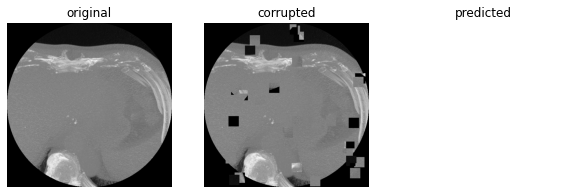

Epoch 367/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 368/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 369/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 370/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 371/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


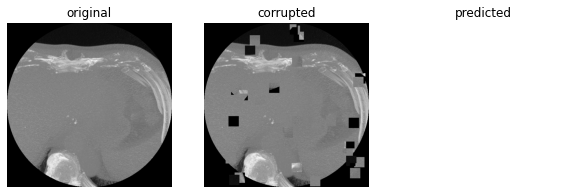

Epoch 372/500
51/51 [==============================] - 16s 314ms/step - loss: nan - val_loss: nan
Epoch 373/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 374/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 375/500
51/51 [==============================] - 16s 312ms/step - loss: nan - val_loss: nan
Epoch 376/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


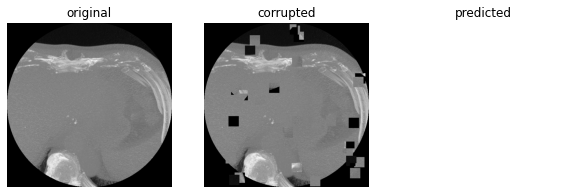

Epoch 377/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 378/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 379/500
51/51 [==============================] - 16s 314ms/step - loss: nan - val_loss: nan
Epoch 380/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 381/500
51/51 [==============================] - 16s 316ms/step - loss: nan - val_loss: nan


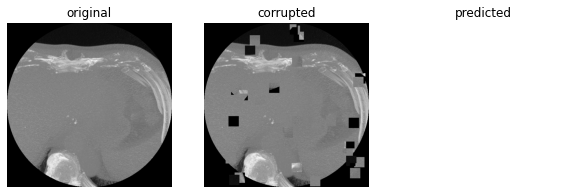

Epoch 382/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 383/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 384/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 385/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan
Epoch 386/500
51/51 [==============================] - 16s 313ms/step - loss: nan - val_loss: nan


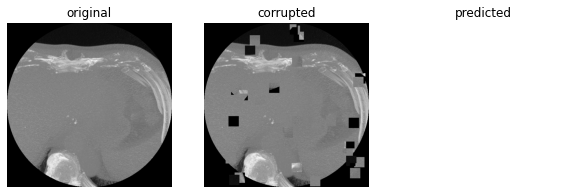

Epoch 387/500
49/51 [===========================>..] - ETA: 0s - loss: nan

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

In [ ]:
historyName = 'models/history_' + MODEL_NAME
modelName = 'models/' + MODEL_NAME

model.save(modelName)
with open(historyName, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
exclude=['models/groot_model_LR_0.002_/image.png','models/groot_model_LR_0.002_/image_corrupt.png']
reconstructed = glob('models/groot_model_LR_0.002_/*.png')
reconstructed = [r for r in reconstructed if r not in exclude]
reconstructed.sort()

images = []
for image_path in reconstructed:
    im = plt.imread(image_path)
    images.append(plt.imread(image_path))
images = np.array(images)
reconstructed

In [ ]:
%%time

Figure = plt.figure()
 
# creating a plot
lines_plotted = plt.imshow(images[0], cmap=plt.cm.gray)    

# function takes frame as an input
def AnimationFunction(frame):
 
    # setting y according to frame
    # number and + x. It's logic
    plt.imshow(images[frame], cmap=plt.cm.gray)
     
anim = FuncAnimation(Figure, AnimationFunction, frames=images.shape[0], interval=100)

writervideo = animation.FFMpegWriter(fps=10)
# anim.save('videos/TrainingsVideo.mp4', writervideo)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()